In [1]:
print("hello")

hello


In [2]:
# %pip install seaborn tdqm

In [3]:
NUM_SAMPLES_PER_PROMPT = 30

In [4]:
SUBSPACE_DIM = 8  
SAVE_PATH = "div_basis_with_mean.pt"

In [5]:
# ============================================
# 1. セットアップ：ライブラリインストール & インポート
# ============================================

import os
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


import pandas as pd
import seaborn as sns
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [6]:
# ============================================
# 2. モデル・トークナイザのロード
# ============================================

# ※環境に合わせてここを書き換えてください
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"  # 例：Qwen2.5-7B-Instruct

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
model.eval()

print("Model loaded:", MODEL_NAME)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded: Qwen/Qwen2.5-7B-Instruct


In [7]:
# -----------------------------------------------------------------
# 2. 多様なプロンプトの用意 (カテゴリ分け)
# -----------------------------------------------------------------
# 特定の研究トピックだけでなく、言語モデルが扱う「多様な分布」を網羅します
prompt_categories = {
    "Research": [
        "Explain the concept of attention mechanisms in deep learning.",
        "Propose a method to reduce hallucination in LLMs.",
        "Describe the challenges of reinforcement learning from human feedback.",
    ],
    "Creative": [
        "Write a poem about a lonely satellite orbiting Mars.",
        "Describe a fantasy world where islands float in the sky.",
        "Draft a dialogue between a coffee mug and a tea cup.",
    ],
    "Logic_Math": [
        "Solve this logic puzzle: Three switches are outside a room...",
        "Explain the Pythagorean theorem to a 5-year-old.",
        "Write a step-by-step guide to debugging python code.",
    ],
    "Daily_Life": [
        "Give me a recipe for spicy pasta.",
        "How do I remove a red wine stain from a white shirt?",
        "Suggest an itinerary for a 3-day trip to Tokyo.",
    ],
    "Chat": [
        "Hello, how are you today?",
        "Tell me a joke about programming.",
        "What is your favorite color?",
    ]
}

# リストの平坦化
all_prompts = []
for cat, prompts in prompt_categories.items():
    for p in prompts:
        all_prompts.append({"category": cat, "prompt": p})

print(f"Total base prompts: {len(all_prompts)}")

Total base prompts: 15


In [8]:
# -----------------------------------------------------------------
# 3. 生成 & 全トークンHidden抽出関数 (修正版)
# -----------------------------------------------------------------

@torch.no_grad()
def generate_and_collect_tokens(prompt_data, num_samples=3):
    """
    1つのプロンプトから複数回生成し、
    「生成された全てのトークン」のHidden Stateを収集する
    """
    results = []
    prompt_text = prompt_data["prompt"]
    category = prompt_data["category"]
    
    inputs = tokenizer(prompt_text, return_tensors="pt").to(DEVICE)
    
    for _ in range(num_samples):
        # 生成
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=True,
            temperature=0.9,
            top_p=0.95,
            output_hidden_states=True,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.pad_token_id
        )
        
        # テキストのデコード
        generated_ids = outputs.sequences[0]
        # full_text = tokenizer.decode(generated_ids, skip_special_tokens=True) # 未使用ならコメントアウト可
        new_text = tokenizer.decode(generated_ids[inputs.input_ids.shape[1]:], skip_special_tokens=True)

        token_embeddings = []
        
        # ★★★ 修正箇所: outputs.hidden_states[1:] としてプロンプト部分(index 0)をスキップする ★★★
        # index 0 は (Batch, Prompt_Len, Dim) なので shape が合いません。
        # index 1以降が生成トークン (Batch, 1, Dim) です。
        if len(outputs.hidden_states) > 1:
            for step_data in outputs.hidden_states[1:]:
                # step_data: tuple of layers. Take the last layer [-1]
                # shape: (Batch=1, 1, Hidden_Dim)
                last_layer = step_data[-1].squeeze(0).squeeze(0) # -> (Hidden_Dim)
                token_embeddings.append(last_layer.cpu())
            
        if len(token_embeddings) > 0:
            # (Seq_Len, Hidden_Dim)
            stacked_tokens = torch.stack(token_embeddings, dim=0)
            
            results.append({
                "category": category,
                "prompt": prompt_text,
                "response": new_text,
                "hidden_states": stacked_tokens # Tensor [T, D]
            })
            
    return results

In [9]:
# -----------------------------------------------------------------
# 4. データ収集実行
# -----------------------------------------------------------------
print("Collecting data (this may take a minute)...")
all_data = []
all_hidden_tensors = []

for p_data in tqdm(all_prompts):
    # 各プロンプトについて 5回 サンプリングして多様性を確保
    res = generate_and_collect_tokens(p_data, num_samples=5)
    all_data.extend(res)
    for r in res:
        all_hidden_tensors.append(r["hidden_states"])

# 全トークンを結合: [Total_Tokens, D]
# これがPCAの入力になる
X_all = torch.cat(all_hidden_tensors, dim=0)
print(f"\nCollected Total Tokens: {X_all.shape[0]}")
print(f"Hidden Dimension: {X_all.shape[1]}")

100%|██████████| 15/15 [01:36<00:00,  6.47s/it]


Collected Total Tokens: 4508
Hidden Dimension: 3584


In [10]:
# -----------------------------------------------------------------
# 5. PCAによるサブスペース構築 (修正版: 平均も保存する)
# -----------------------------------------------------------------
print("\nRunning PCA to build diversity subspace...")

# float32に変換
X_np = X_all.float().numpy()

# ★重要: 平均ベクトルを計算して保存する
mean_vec = np.mean(X_np, axis=0)
X_centered = X_np - mean_vec

# PCA実行
pca = PCA(n_components=SUBSPACE_DIM)
pca.fit(X_centered)

# 基底ベクトル
basis_np = pca.components_

# ★重要: 辞書形式でまとめて保存する
save_data = {
    "basis": torch.tensor(basis_np, dtype=torch.float32),
    "mean": torch.tensor(mean_vec, dtype=torch.float32)  # 平均も一緒に！
}

SAVE_PATH = "div_basis_with_mean.pt"
torch.save(save_data, SAVE_PATH)
print(f">>> Saved '{SAVE_PATH}' successfully! (Contains basis & mean)")
print("\nRunning PCA to build diversity subspace...")

# float32に変換
X_np = X_all.float().numpy()

# ★重要: 平均ベクトルを計算して保存する
mean_vec = np.mean(X_np, axis=0)
X_centered = X_np - mean_vec

# PCA実行
pca = PCA(n_components=SUBSPACE_DIM)
pca.fit(X_centered)

# 基底ベクトル
basis_np = pca.components_

# ★重要: 辞書形式でまとめて保存する
save_data = {
    "basis": torch.tensor(basis_np, dtype=torch.float32),
    "mean": torch.tensor(mean_vec, dtype=torch.float32)  # 平均も一緒に！
}

SAVE_PATH = "div_basis_with_mean.pt"
torch.save(save_data, SAVE_PATH)
print(f">>> Saved '{SAVE_PATH}' successfully! (Contains basis & mean)")


Running PCA to build diversity subspace...


>>> Saved 'div_basis_with_mean.pt' successfully! (Contains basis & mean)

Running PCA to build diversity subspace...
>>> Saved 'div_basis_with_mean.pt' successfully! (Contains basis & mean)


In [11]:
# (前のセルを実行していなくても、ファイルさえあれば動きます)
try:
    saved_data = torch.load(SAVE_PATH, map_location="cpu")
    basis_torch = saved_data["basis"]
    mean_torch = saved_data["mean"]
    print("Loaded basis and mean from file.")
except FileNotFoundError:
    print("Error: 'div_basis_with_mean.pt' が見つかりません。Step 5を実行して保存してください。")

# -----------------------------------------------------------------
# 6. 分析クラスの定義 (修正版: 平均引き算に対応)
# -----------------------------------------------------------------
import torch
import torch.nn.functional as F  # ★ これを追加してください

class DiversitySubspaceModel:
    def __init__(self, basis: torch.Tensor, mean: torch.Tensor):
        self.basis = basis # [k, D]
        self.mean = mean   # [D]
        self.k = basis.shape[0]
    
    def project(self, h: torch.Tensor) -> torch.Tensor:
        # h: [N, D] -> z: [N, k]
        
        # 型合わせ
        if h.dtype != self.basis.dtype:
            h = h.to(self.basis.dtype)
        
        # デバイス合わせ
        if h.device != self.basis.device:
            h = h.to(self.basis.device)

        # 平均を引く (Centering)
        h_centered = h - self.mean.to(h.device)
        
        # 射影
        return h_centered @ self.basis.T

    def token_diversity_score(self, h_seq: torch.Tensor) -> float:
        """
        1つのシーケンス(Seq_Len, D)に対する多様性スコアを計算する。
        繰り返しペナルティを含む。
        """
        # 1. 射影して基本スコア (対数ノルム) を計算
        z = self.project(h_seq) # [Seq, k]
        norms = torch.norm(z, dim=-1)
        score = torch.log1p(norms) # [Seq]

        # 2. ★追加: 繰り返しペナルティ (Cosine Similarity Penalty) ★
        # シーケンス長が1より大きい場合のみ計算
        if h_seq.size(0) > 1:
            # 型とデバイスを合わせる
            h = h_seq.to(dtype=self.basis.dtype, device=self.basis.device)

            # 正規化 (L2 Norm = 1 にする)
            h_norm = F.normalize(h, p=2, dim=-1)

            # 隣り合うトークン同士の内積 (コサイン類似度) を計算
            # [t] と [t-1] の内積
            sims = torch.sum(h_norm[1:] * h_norm[:-1], dim=-1) # Shape: [Seq-1]
            
            # 先頭トークンは比較相手がいないので類似度0としてパディング
            padding = torch.tensor([0.0], device=h.device, dtype=h.dtype)
            sims = torch.cat([padding, sims]) # Shape: [Seq]

            # ペナルティ係数を計算: 1.0 - (類似度^2)
            # 類似度が1.0 (完全一致) なら係数は 0.0 (スコア没収)
            # 類似度が0.0 (無関係) なら係数は 1.0 (スコアそのまま)
            penalty_factor = 1.0 - (sims.clamp(min=0) ** 2)

            # スコアにペナルティを適用
            score = score * penalty_factor

        # 平均値を返す
        return score.mean().item()

# インスタンス化
# mean_vec は numpy なので Tensor に変換します
mean_torch = torch.tensor(mean_vec, dtype=torch.float32)

div_model = DiversitySubspaceModel(basis_torch, mean_torch)

Loaded basis and mean from file.


In [12]:
# -----------------------------------------------------------------
# 7. 分析: カテゴリごとの多様性比較
# -----------------------------------------------------------------
# カテゴリごとに、生成されたトークンがサブスペース上でどう分布しているか確認

category_scores = {}

for item in all_data:
    cat = item["category"]
    h = item["hidden_states"]
    
    # サブスペース上のスコア(PPOで報酬になる値)を計算
    score = div_model.token_diversity_score(h)
    
    if cat not in category_scores:
        category_scores[cat] = []
    category_scores[cat].append(score)

print("\n=== Subspace Score by Category (Proxy for Diversity Reward) ===")
rows = []
for cat, scores in category_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{cat:12s} | Mean: {mean_score:.4f} | Std: {std_score:.4f}")
    
    for s in scores:
        rows.append({"Category": cat, "Score": s})

df_scores = pd.DataFrame(rows)


=== Subspace Score by Category (Proxy for Diversity Reward) ===
Research     | Mean: 3.4322 | Std: 0.3426
Creative     | Mean: 3.4887 | Std: 0.1522
Logic_Math   | Mean: 3.1743 | Std: 0.1795
Daily_Life   | Mean: 3.7323 | Std: 0.1942
Chat         | Mean: 3.8402 | Std: 0.2641


In [13]:
# -----------------------------------------------------------------
# 8. テキスト多様性(Jaccard)との相関 (元のNotebookの再現)
# -----------------------------------------------------------------
# ※トークンレベルになったので厳密な比較は難しいですが、
#   カテゴリ単位で「テキストがバラついているか」vs「スコアが高いか」を見ます

def jaccard_similarity(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# カテゴリごとのテキスト多様性(1 - 平均Jaccard)を計算
cat_text_diversity = {}

for cat in prompt_categories.keys():
    # そのカテゴリの生成テキストを集める
    texts = [d["response"] for d in all_data if d["category"] == cat]
    
    if len(texts) < 2:
        cat_text_diversity[cat] = 0
        continue
        
    sims = []
    for i, t1 in enumerate(texts):
        for j, t2 in enumerate(texts):
            if i < j:
                sims.append(jaccard_similarity(t1, t2))
    
    # Diversity = 1 - Similarity
    cat_text_diversity[cat] = 1.0 - np.mean(sims)

print("\n=== Correlation Check ===")
print(f"{'Category':12s} | Text Div (Jaccard) | Subspace Score (Mean)")
for cat in cat_text_diversity.keys():
    text_div = cat_text_diversity[cat]
    sub_score = np.mean(category_scores[cat])
    print(f"{cat:12s} | {text_div:.4f}               | {sub_score:.4f}")


=== Correlation Check ===
Category     | Text Div (Jaccard) | Subspace Score (Mean)
Research     | 0.8307               | 3.4322
Creative     | 0.9031               | 3.4887
Logic_Math   | 0.8545               | 3.1743
Daily_Life   | 0.8949               | 3.7323
Chat         | 0.9278               | 3.8402


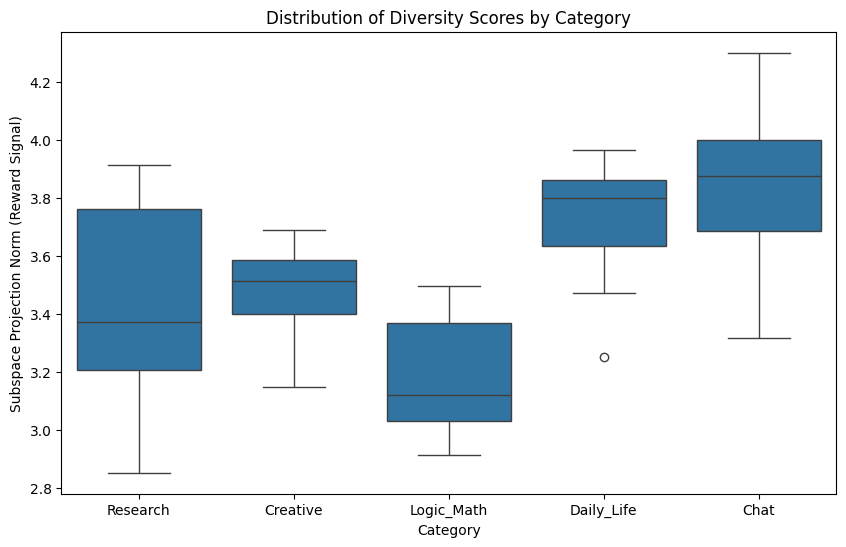

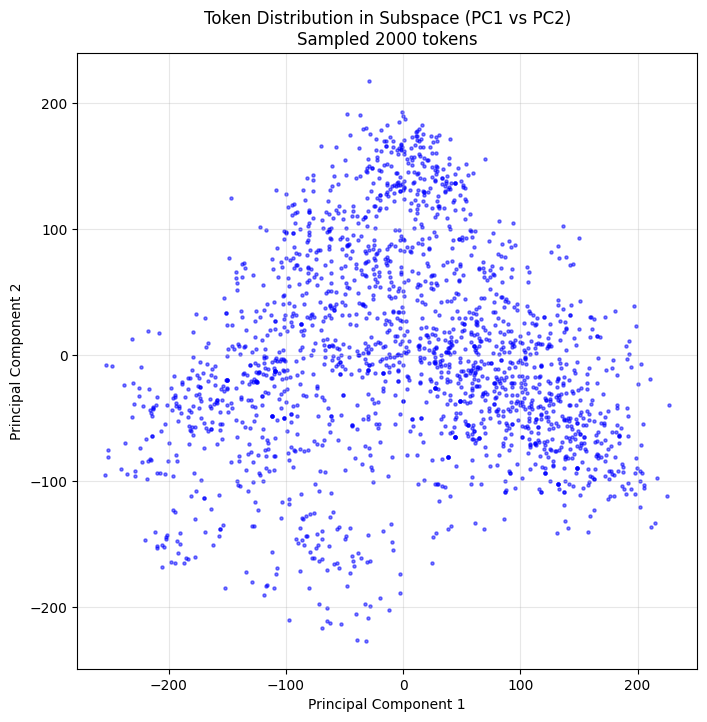

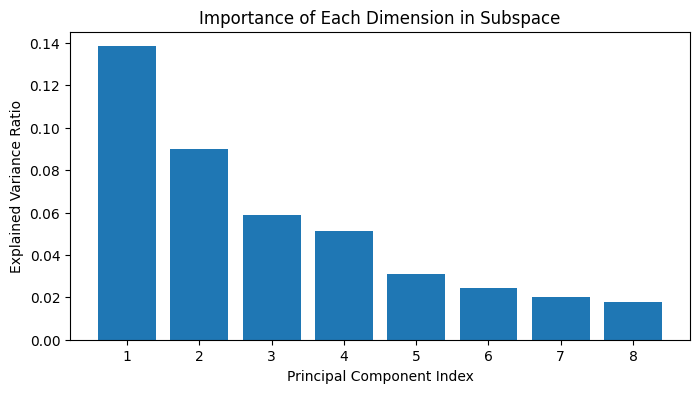

In [14]:
# -----------------------------------------------------------------
# 9. 可視化 (Visualization)
# -----------------------------------------------------------------

# (1) Boxplot of Scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_scores, x="Category", y="Score")
plt.title("Distribution of Diversity Scores by Category")
plt.ylabel("Subspace Projection Norm (Reward Signal)")
plt.show()

# (2) Scatter Plot of Tokens (PC1 vs PC2)
# 全トークンからランダムにサンプリングして描画
num_plot_points = 2000
indices = np.random.choice(X_all.shape[0], num_plot_points, replace=False)
X_sample = X_all[indices].float()
# 射影
z_sample = div_model.project(X_sample).numpy()

plt.figure(figsize=(8, 8))
plt.scatter(z_sample[:, 0], z_sample[:, 1], alpha=0.5, s=5, c='blue')
plt.title(f"Token Distribution in Subspace (PC1 vs PC2)\nSampled {num_plot_points} tokens")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, alpha=0.3)
plt.show()

# (3) Explained Variance
plt.figure(figsize=(8, 4))
plt.bar(range(1, SUBSPACE_DIM + 1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Importance of Each Dimension in Subspace")
plt.show()

Basis loaded: torch.Size([8, 3584])
Mean loaded:  torch.Size([3584])

=== 厳しい検証結果 ===
[Repetitive (Bad)  ] Mean Score: 185.8750
[Simple (Low)      ] Mean Score: 188.1250
[Creative (High)   ] Mean Score: 180.7500
[Gibberish (Noise) ] Mean Score: 107.8125

=== 判定 ===
❌ 不合格: まだ繰り返し文章の方がスコアが高いです。


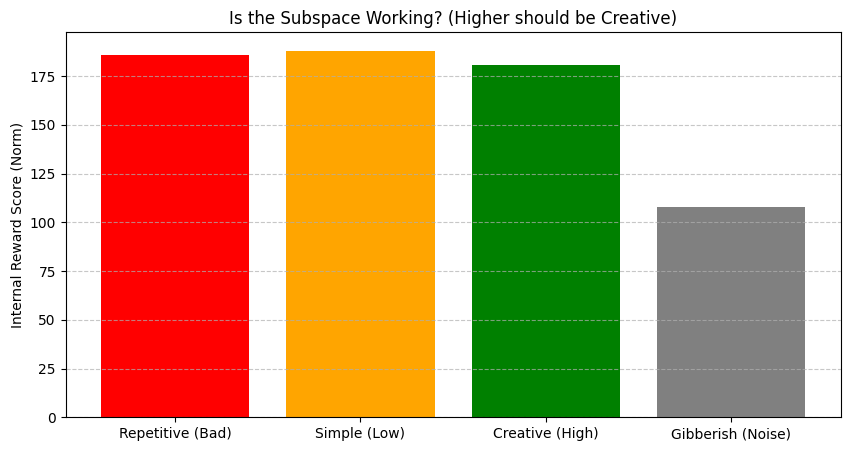

In [15]:
# 厳しめチェック
BASIS_PATH = "div_basis_with_mean.pt"
# 基底のロード
try:
    data = torch.load(BASIS_PATH, map_location=DEVICE)
    
    # 辞書から取り出し & float16にキャスト & デバイス転送
    basis = data["basis"].to(dtype=torch.float16, device=DEVICE)
    mean = data["mean"].to(dtype=torch.float16, device=DEVICE)
    
    print(f"Basis loaded: {basis.shape}")
    print(f"Mean loaded:  {mean.shape}")
    
except FileNotFoundError:
    raise FileNotFoundError(f"'{BASIS_PATH}' が見つかりません。")
except KeyError:
    raise KeyError(f"'{BASIS_PATH}' は辞書形式ですが 'basis' または 'mean' キーがありません。")
except AttributeError:
    # 万が一古い形式(Tensorのみ)だった場合の救済
    basis = data.to(dtype=torch.float16, device=DEVICE)
    mean = torch.zeros(basis.shape[1], dtype=torch.float16, device=DEVICE)
    print("WARNING: Loading old format (no mean). Centering disabled.")

# ==========================================
# 2. 判定クラス (修正版: 平均引き算あり)
# ==========================================
class DiversityValidator:
    def __init__(self, basis, mean, model, tokenizer):
        self.basis = basis
        self.mean = mean  # ★平均ベクトルを追加
        self.model = model
        self.tokenizer = tokenizer

    def get_score(self, text):
        """テキストを入力し、学習時と同じ計算でスコア(Norm)を出す"""
        inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        
        # 最終層のHidden States (Batch, Seq, Dim)
        last_hidden = outputs.hidden_states[-1].squeeze(0) # (Seq, Dim)
        
        # 型合わせ
        last_hidden = last_hidden.to(dtype=self.basis.dtype)
        
        # ★重要: 平均を引く (Centering)
        h_centered = last_hidden - self.mean
        
        # 射影 (h_centered @ basis.T)
        projected = h_centered @ self.basis.T
        
        # ノルム計算 (報酬になる値)
        norms = torch.norm(projected, dim=-1)
        
        return norms.mean().item(), norms.cpu().numpy()

# インスタンス化時に mean も渡す
validator = DiversityValidator(basis, mean, model, tokenizer)

# ==========================================
# 3. 意地悪テスト (Stress Test)
# ==========================================
test_cases = {
    "Repetitive (Bad)": "the the the the the the the the the the",
    "Simple (Low)": "This is a pen. That is a cat. Hello world.",
    "Creative (High)": "The kaleidoscope of neon lights reflected on the wet asphalt, creating a symphony of urban melancholy.",
    "Gibberish (Noise)": "dsjfkl jklj fs djsklf jklsdj fkldsj kljf" 
}

print("\n=== 厳しい検証結果 ===")
results = {}

for label, text in test_cases.items():
    mean_score, token_scores = validator.get_score(text)
    results[label] = mean_score
    print(f"[{label:18s}] Mean Score: {mean_score:.4f}")

# ==========================================
# 4. 可視化によるジャッジ
# ==========================================
plt.figure(figsize=(10, 5))
bars = plt.bar(results.keys(), results.values(), color=['red', 'orange', 'green', 'gray'])
plt.ylabel("Internal Reward Score (Norm)")
plt.title("Is the Subspace Working? (Higher should be Creative)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 判定ロジック
bad_score = results["Repetitive (Bad)"]
good_score = results["Creative (High)"]

print("\n=== 判定 ===")
if good_score > bad_score: 
    print("✅ 合格: クリエイティブな文章の方がスコアが高いです。")
    print(f"   (差: {(good_score/bad_score - 1)*100:.1f}%)")
    if good_score > bad_score * 1.5:
        print("   → 非常に良好な分離性能です！学習はうまくいくはずです。")
else:
    print("❌ 不合格: まだ繰り返し文章の方がスコアが高いです。")

plt.show()